# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Load the data from the hub.

In [ ]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/fine-tuning-instruct-aira", split="aira_instruct_english")

df = dataset.to_pandas()

display(df)

prompt  \
0               Which is a species of fish? Tope or Rope   
1         Why can camels survive for long without water?   
2      Alice's parents have three daughters: Amy, Jes...   
3       Who gave the UN the land in NY to build their HQ   
4                            Why mobile is bad for human   
...                                                  ...   
53129  How do computers communicate and network with ...   
53130  How are websites different from web applications?   
53131     What is open-source software and its benefits?   
53132  What is a cookie and how is it used in web bro...   
53133  What is cloud storage and its advantages for d...   

                                              completion  
0                                                   Tope  
1      Camels use the fat in their humps to keep them...  
2                The name of the third daughter is Alice  
3                                    John D Rockerfeller  
4      We are always engaged one phone which is not g...  
...                                                  ...  
53129  Computers communicate and network with each ot...  
53130  Websites and web applications are similar in t...  
53131  Open-source software is software that is made ...  
53132  A cookie is a small piece of data that a websi...  
53133  Cloud storage is a service that allows you to ...  

[53134 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [ ]:
from transformers import GPT2Tokenizer

model = "gpt2-xl" # "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "pierreguillou/gpt2-small-portuguese"
model_size = "1.5B" # "124M", "355M", "774M", and "1.5B", "PT-124M"

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  53134
The longest demonstration is 300 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, gpt2_type="gpt2", max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [ ]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 47,820
Number of validation samples: 5,314


8. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=4 # 32, 20, 8, 4
        )

# validation data loader doesn't need randomization
validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=4
        )

9. Load the base model (`GPT2LMHeadModel`).

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50259, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 12 #6, 8, 9, 12

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  48
Number of transformer blocks to  un-freeze:  12
Number of frozen layers: 433
Number of trainable layers: 147


11. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 2 # 5, 3, 2, 2

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [11]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'your_path_to_output_dir'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 2



  3%|▎         | 400/11955 [04:41<2:13:56,  1.44it/s]


Batch 400 of 11955. Loss:1.1654434204101562.


Example output: What is open-source software and its benefits?Computer science is the subfield of computer science that examines the intricate relationship between machines and humans, and examines how such relationships should be created and modified. It is essential for today's technology environment, and plays a crucial role in creating technologies that are ever more accessible, responsive, and responsive. In addition, machine learning can be utilized to solve intricate problems, such as creating AI tools that can recognize and respond appropriately to human emotions or emotions themselves. This enables users to express themselves and respond to emotions themselves, which is a big area of focus for artificial intelligence, where machine learning is utilized to learn and respond appropriately to emotions itself, and this is where deep learning is utilized to model and respond appropriately to emotions themselves. Machine learning is ut

  7%|▋         | 800/11955 [09:31<2:09:46,  1.43it/s]


Batch 800 of 11955. Loss:0.6719180345535278.


Example output: I am writing an academic essay on the economy, can you provide some sources or references to help me with my research.Sure! A computer program was developed to analyze the effects of the war on the economy and the economy was monitored while the war was ongoing. It found that the economy as a whole was relatively stable during the war and was relatively positive afterwards. However, some businesses saw greater returns on their investment during the war and it is possible that some of the businesses benefited because they had the right equipment or they had a good idea. Other businesses may have become more successful during the war due to the need for more resources to be available while still others may have become more successful for other reasons.



 10%|█         | 1200/11955 [14:17<2:04:41,  1.44it/s]


Batch 1200 of 11955. Loss:0.5023787617683411.


Example output: What is the role of convolutional neural network in machine learning?In order to learn more about the relationship between neural networks and machine learning, I suggest you start by reading the Neural Network Labeling and Local Area Neural Network (LNN) Neural Network: A Guide for Students and developers. The complete study and explanation is freely available online at Udemy, so you could easily find it online. It is a great overview of the concepts and practices behind NNNs and LNNs and is an easy-to-read and easy-to-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and-read-and



 13%|█▎        | 1600/11955 [19:05<2:00:07,  1.44it/s]


Batch 1600 of 11955. Loss:1.0423882007598877.


Example output: What are some ways to tour the canals of Amsterdam.The canals of Amsterdam are well developed, but they get more amenities and amenities require more resources. Depending on the size of the lake and the size of the lake beds, they can be able to accommodate many more amenities than other larger lake parks in the Netherlands. While other lake parks in the Netherlands have great amenities, they tend to be larger. You will typically get better value for money in the smaller Lake Canals of Amsterdam, as they tend to have shorter trip times and smaller entrance fee costs, as well as a lower rate of maintenance.



 17%|█▋        | 2000/11955 [23:50<1:55:30,  1.44it/s]


Batch 2000 of 11955. Loss:0.8089869022369385.


Example output: What causes ocean tides?Causes of ocean tides include increasing energy from the Earth's winds, as well as from other atmospheric dynamics. As the waves form, they must move from one location to another in the ocean and the oceans and their habitats need to handle the increased energy from the winds. As the waves form, they must use energy from the Earth's winds and from other atmospheric dynamics to create movement and momentum in the water. As the waves form and move towards each other, they gain speed and power, which causes them to bend the water around their edges. These waves form into a path that is characterized by a peak and a decline. The peak is the point at which the water flows forwards. The decline is the point at which the water flows backward. This creates the visible path from point of peak to point of decline. As the waves move towards each other, they gain momentum and energy. When the waves reach the e

 20%|██        | 2400/11955 [28:39<1:50:51,  1.44it/s]


Batch 2400 of 11955. Loss:0.3757154941558838.


Example output: What is the difference between a meteor, an asteroid and a comet.The main difference between a meteor, an asteroid, and a comet is that a meteor is an tiny bits of dust and dust dust particles, while an Asteroo is a massive cloud of debris, dust, and gas. Asteroids are more likely to burn up in the atmosphere, while objects in the Solar System are less likely to burn up.



 23%|██▎       | 2800/11955 [33:22<1:46:11,  1.44it/s]


Batch 2800 of 11955. Loss:0.5319542288780212.


Example output: What are the symptoms of a UTI.The most common symptoms of a urinary tract infection (UTI) include cloudy or bloody urine, increased urinary frequency, burning sensation, abdominal discomfort, abdominal pain, abdominal cramps, heartburn, and fever. Other signs may include pelvic discomfort and pelvic discomfort and pelvic discomfort and abdominal cramps.



 27%|██▋       | 3200/11955 [38:04<1:41:38,  1.44it/s]


Batch 3200 of 11955. Loss:0.7579741477966309.


Example output: What are the best tips for starting a small business.The best tips for starting a small business include researching, having a plan and staying organized. Start by researching your business objectives and values. Consider what resources available such as mentors, mentors who can help you develop your plan and how you can pay for it. Make sure your plan is realistic and achievable. You may also need to make changes to your plan as needed. Once you have your plan, make sure you focus your effort and focus on making sure your goals are met. Additionally, develop the right marketing strategy to help your business grow and reach your target demographic. Finally, make sure your company is up to date on its security protocols and management procedures.



 30%|███       | 3600/11955 [42:50<1:36:59,  1.44it/s]


Batch 3600 of 11955. Loss:0.5735041499137878.


Example output: What are some tips for maintaining mental health.Eating a balanced diet is one of the key components of maintaining mental state. To ensure that you have the necessary nutrients to maintain a balanced diet, it is important to plan your diet around the nutritious foods that you are exposed to. You should listen to your body and drink plenty of water to stay hydrated. Additionally, practice relaxation techniques such as meditation and deep breathing to reduce stress and increase your energy levels. Lastly, it is important to seek out support from people who are supportive of you and know your individual needs.



 33%|███▎      | 4000/11955 [47:35<1:32:17,  1.44it/s]


Batch 4000 of 11955. Loss:0.5229397416114807.


Example output: What are the components of a business plan.The components of a business plan include a mission statement, a mission and goals, financial projections, a market plan, a funding solution, and an organizational structure.



 37%|███▋      | 4400/11955 [52:15<1:27:42,  1.44it/s]


Batch 4400 of 11955. Loss:0.7181077599525452.


Example output: How do you define a utility function?There are many potential interpretations of the utility function, but one important consideration is the idea of value complexity. This means that when looking at the utility function, consider whether you're looking at the most complex alternatives possible. If you are looking at the most complex options possible, you should consider whether it is possible to solve for all possible values of a parameter by consulting an algorithm. If it is not possible to solve for all possible values by consulting an algorithm, then you should consider whether you are considering all possible alternatives.



 40%|████      | 4800/11955 [56:59<1:22:58,  1.44it/s]


Batch 4800 of 11955. Loss:0.5860748887062073.


Example output: I need to replace the tires on my car, how much should I expect to pay.You should pay the minimum price for the car models you plan to purchase. Generally, you should pay for an electric car and a gas car at the same prices. This allows for an easier comparison, since most electric vehicles are currently priced at the same rate as gasoline-powered vehicles.



 43%|████▎     | 5200/11955 [1:01:41<1:18:23,  1.44it/s]


Batch 5200 of 11955. Loss:0.5548998713493347.


Example output: When was the NFL founded? Which NFL team won the most Super Bowls? Which quarterback has won the most Super Bowls?The National Football League was founded on August 15, 1940 in Seattle, WA, USA. According to the National Football League’s website, the initial goal of the league was to meet the demand for football among American adults, with the intention of expanding into other sports like volleyball, rugby, soccer and handball, among others. The initial success of the league in this regard in 1950 (19,867 athletes), put the name of the league on the table in 1960, when a vote was held to name the league after the first name the first owner of the Baltimore Baltimore Baltimore Baltimore Baltimore Baltimore Baltimore Baltimore franchise would take as the name of the franchise. The name of the first owner was Walter Washington, the founder of the Baltimore Baltimore Baltimore Baltimore Baltimore Baltimore Baltimore Baltimor

 47%|████▋     | 5600/11955 [1:06:29<1:13:42,  1.44it/s]


Batch 5600 of 11955. Loss:0.5516342520713806.


Example output: How do I make shortbread cookies.Start by preheating your oven to 350° F (180° C).
2  Roll out the cookie dough and fold it into half. Place the folded dough into the bottom of a 9-inch (23-cm) 9-inch (23-cm) cookie sheet.
3  Pour the melted butter into a 9-inch (23-cm) 9-inch (23-cm) cookie sheet.
4  Top with a 9-inch (23-cm) 9-inch (23-cm) cookie sheet.
5  Flatten the bottom of the dough with the bottom of the cookie sheet.
6  Flatten the top of the dough with the top of the cookie sheet.
7  Bake for 15-20 minutes.
8  Cool for 10 minutes.
9  Allow the cookies to cool for 10 minutes before serving. Enjoy.



 50%|█████     | 6000/11955 [1:11:18<1:09:03,  1.44it/s]


Batch 6000 of 11955. Loss:0.6980631351470947.


Example output: How can I learn something new every day.One way to learn new skills or knowledge every day is to practice it at home. Start with small projects such as writing, drawing, writing and drawing games. Practice new skills every day and gradually build on them. You will become comfortable with the new skills and be more comfortable with the concepts they are trying to solve. Additionally, you will learn the concepts related to the new skill, so you will also be able to use them while writing, drawing, writing and drawing games. You may also want to start studying resources like tutorials, apps and online resources such as tutorials and apps that can help you learn new skills. Finally, you should also take regular breaks to rest and recharge, as well as be consistent in your practice and focus on understanding the concepts and concepts you are trying to learn.



 54%|█████▎    | 6400/11955 [1:16:06<1:04:25,  1.44it/s]


Batch 6400 of 11955. Loss:0.4096757769584656.


Example output: Is it wise to invest all of one's money in cryptocurrency?It depends. Cryptocurrency is currently an alternative asset asset class to traditional investments such as stocks and bonds, and there are potential risks and rewards. Cryptocurrency is known for providing users with access to the markets that have typically been inaccessible or difficult to access for residents of certain countries. Furthermore, as a blockchain-based technology, Cryptocurrency carries greater value than what it stands as today. Ultimately, the decision of which cryptocurrencies is right for you should depend on your financial goals, timeline, and risk appetite.



 57%|█████▋    | 6800/11955 [1:20:50<59:46,  1.44it/s]


Batch 6800 of 11955. Loss:0.768928050994873.


Example output: How do I archive old emails.Start by creating a new filing cabinet or sorting list on your computer. This will help you keep all of your important emails and programs in one place. Next, install delete-on-read-only software on your computer. This will prevent any emails from being stored, delete any emails from your computer, and block any from getting in your computer or getting in your browser. Make sure to scan your computer for any broken or suspicious software, and remove any that can be found. You may also need to replace any RAM or hard drive that could be causing issues. After the issue is patched, open the file management settings of your computer and delete any unnecessary files. Finally, clean up any clutter that may have built up.



 60%|██████    | 7200/11955 [1:25:37<55:09,  1.44it/s]


Batch 7200 of 11955. Loss:0.7014164328575134.


Example output: What is the perfect place for my family to vacation this summer.The best place for your family to vacation this summer is the ocean. With so many exciting activities for a couple of family members, you will be sure to see a variety of places and attractions. A warm summer evening could be made up of visiting the local bars, taking the stairs to the upper floor of a building, and cooking a delicious meal in a food storage room. For an opportunity to experience all aspects of the summer, visiting an amusement park could be a great option. Whether it's going to a different outdoor activity every day of the week or even visiting the amusement park on a weekends, the most popular places to visit for your family are the beach and beach vacations.



 64%|██████▎   | 7600/11955 [1:30:23<50:30,  1.44it/s]


Batch 7600 of 11955. Loss:0.8305400013923645.


Example output: Which is a species of fish? Lizard or LizardfishBanjofish



 67%|██████▋   | 8000/11955 [1:35:02<45:53,  1.44it/s]


Batch 8000 of 11955. Loss:0.9570227861404419.


Example output: I'm having trouble concentrating. What tips can help me focus and stay on task.Make a list of all the time-wasting activities you are trying to minimize and prioritize them. Consider the time-wasting activities ahead of time, and set aside a specific amount of time each day for yourself to focus on them.
2. Set a schedule of upcoming tasks and commitments that you can stick to. Take breaks when you're having trouble concentrating, but take a little bit of time to give yourself a little break too.
3. Make sure to practice good time management skills. Take a few deep breaths, think of a few facts or ideas for the next month, and then put together a timeline for how you want to complete them.
4. Find a designated workspace that is comfortable and free from distractions. This can be in a quiet space, like a room with two windows or a balcony, or even in the back of a house with a few chairs and a ceiling



 70%|███████   | 8400/11955 [1:39:51<41:20,  1.43it/s]


Batch 8400 of 11955. Loss:0.6780582070350647.


Example output: What are some jobs that are around the world related to computers.Some jobs that could fit into this list include software developer, data analyst, and analyst.



 74%|███████▎  | 8800/11955 [1:44:31<36:37,  1.44it/s]


Batch 8800 of 11955. Loss:0.6122076511383057.


Example output: What is the nearest hardware store to my location.The closest hardware store to your location is typically about halfway between you and the nearest Starbucks or Starbucks Cafe.



 77%|███████▋  | 9200/11955 [1:49:11<31:59,  1.44it/s]


Batch 9200 of 11955. Loss:0.382173091173172.


Example output: What hit song that was used in the Bollywood movie Don actually a reject from an earlier movie.Yes, Don was a hit song that was used in the Bollywood movie Don. The song was originally a theme song from a movie called A Drama of Life. The theme song was a huge hit in the early 1980s and was one of the biggest hit song in Bollywood history.



 80%|████████  | 9600/11955 [1:53:53<27:19,  1.44it/s]


Batch 9600 of 11955. Loss:0.5627954006195068.


Example output: What is the significance of balancing autonomy and democratic values in the governance of AI?The principle of autonomy postulates that the decision-making power to make decisions should be made by individuals only when it is feasible for them to do so. This is also known as the autonomy of individuals.



 84%|████████▎ | 10000/11955 [1:58:34<22:41,  1.44it/s]


Batch 10000 of 11955. Loss:0.7716888189315796.


Example output: Can you review a ledger for accounting accuracy.There are many ways to review a ledger. A manual review would require a list of all entries, along with a description of what the entries are and the date they came in. An automated review could analyze the data provided by the transactions as well as the user's response. A automated response includes tracking the data as it is entered and withdrawals be monitored to ensure the entries have been properly recorded. Finally, an automated response may be used to identify any errors, errors made by the user, or errors made during the setup process.



 87%|████████▋ | 10400/11955 [2:03:19<18:04,  1.43it/s]


Batch 10400 of 11955. Loss:0.4592054486274719.


Example output: What is a good recipe for a vegan black bean soup.A good vegan black bean soup is made with ground black beans, sautéed onion, garlic, onion powder, and spices of your choice. You can add other spices like cumin, smoked paprika, cayenne pepper, and smoked paprika powder if you want it more nutty or sauté it in garlic butter. Enjoy.



 90%|█████████ | 10800/11955 [2:08:02<13:24,  1.43it/s]


Batch 10800 of 11955. Loss:0.3857034146785736.


Example output: I'm trying to memorize pi to 10 digits. Can you help me out.I'm sorry, I'm not able to help you out with this task. It is a complex matter of memorizing a number sequence with multiple numbers sequence as a sequence of numbers with multiple digits. It is difficult for me to provide you with a useful answer.



 94%|█████████▎| 11200/11955 [2:12:44<08:54,  1.41it/s]


Batch 11200 of 11955. Loss:0.606650710105896.


Example output: Could the "Embedded agency" model be applied in all industries?The concept of Embodied Agency suggests that rational agent theory should consider the agent as the primary example of the agent's current state of existence. This means that agents should be thought of as integrated into the world they exist in, rather than as distinct from it.



 97%|█████████▋| 11600/11955 [2:17:26<04:07,  1.44it/s]


Batch 11600 of 11955. Loss:0.5445802807807922.


Example output: Does acupuncture really have a scientific basis.Yes, acupuncture has a scientific basis. Acupuncture is a form of physical therapy that focuses on the connection between the body and the environment in order to treat illnesses with a focus on acupuncture medicine. Acupuncture is based on principles of quantum theory, which posits that there are several possible ways in which the physical world could be seen, experienced, or modified by changing the behavior of a particular object. This means that many different treatments can be expected to work, with the focus being on improving patient health rather than just any physical performance.



100%|██████████| 11955/11955 [2:21:39<00:00,  1.41it/s]



Average Training Loss: 0.7232662604075504.


Validation loss: 0.6367488981773299.


Beginning epoch 2 of 2



  3%|▎         | 400/11955 [04:38<2:14:13,  1.43it/s]


Batch 400 of 11955. Loss:0.4304645359516144.


Example output: What are the symptoms of a broken arm.The most common symptoms of a broken arm include numbness, tingling, tingling or tinglingness in the arms and hands; numbness or tingling on one hand; numbness or tingling on the right side; numbness or tingling in one hand; and weakness or numbness in the arms or hands.



  7%|▋         | 800/11955 [09:21<2:09:42,  1.43it/s]


Batch 800 of 11955. Loss:0.42402124404907227.


Example output: What is the definition of intelligence?The term intelligence is often connote as an innate ability that humans possess, unlike animals or humans. However, it is widely acknowledged that humans do not have an innate ability to learn and apply new knowledge in an efficient and effective manner.



 10%|█         | 1200/11955 [14:03<2:04:54,  1.44it/s]


Batch 1200 of 11955. Loss:0.4674263000488281.


Example output: How do you define general artificial intelligence?General Intelligence refers to the ability to effectively achieve goals across different circumstances. Artificial General Intelligence pertains to the ability to achieve goals at any given time, irrespective of the circumstances. Artificial General Intelligence is non-human inspired and relies on machine learning rather than human intellect.



 13%|█▎        | 1600/11955 [18:45<2:00:08,  1.44it/s]


Batch 1600 of 11955. Loss:0.5717531442642212.


Example output: I have a lot of books on my shelf and I'm looking for a reliable system to organise them. What would you suggest.I would recommend starting with a book list and sticking to it. Once you’ve established the order, you can decide which books you want to keep and which you don't. It can be helpful to divide the books into “soft” and “hard” genres so that you can find the ones that you enjoy the most or that you are most able to teach effectively. Additionally, you can create categories for each book such as “useful” or “unethical” so that you can search for those that you have difficulty with. Finally, you can create sections for each book, such as “ chapters” or “ sections” so you can stay on top of the topic and get a better understanding of what you are talking about.



 17%|█▋        | 2000/11955 [23:32<1:55:24,  1.44it/s]


Batch 2000 of 11955. Loss:0.3633972704410553.


Example output: How can I go about negotiating a higher salary.To negotiate a higher salary, it is important to do your homework, be prepared, and be confident. Before beginning the negotiation process, it is important to have an understanding of the salary range in your desired company and the compensation packages of the most qualified team members. Make sure to research salary ranges, salary packages, and other salary-related terms in case you need to make adjustments when negotiating. Additionally, be prepared to discuss salary with coworkers to help ensure an equitable and fair salary is agreed upon. Try to stay in touch with colleagues to stay up to date on current salary trends and ask for feedback and advice on how to best negotiate.



 20%|██        | 2400/11955 [28:18<1:50:48,  1.44it/s]


Batch 2400 of 11955. Loss:0.45226219296455383.


Example output: What is the fastest way to defrost a turkey.The fastest way to defrost a turkey is to place it in the refrigerator overnight.



 23%|██▎       | 2800/11955 [32:57<1:46:13,  1.44it/s]


Batch 2800 of 11955. Loss:0.8627551198005676.


Example output: What are some good ways to reduce anxiety.Some good ways to reduce anxiety include:
1. Exercise regularly.
2. Get enough sleep.
3. Get adequate sleep hygiene.
4. Eat a nutritious diet.
5. Talk about your worries or concerns.
6. Develop a plan to manage stress.
7. Prioritize tasks.
8. Talk to a mental health professional.
9. Take time for yourself.
10. Connect with others.



 27%|██▋       | 3200/11955 [37:41<1:41:27,  1.44it/s]


Batch 3200 of 11955. Loss:0.3708806335926056.


Example output: What are some good dinner recipes for a family of five.Grilled Salmon and Quinoa Bowl: This vegetarian chili recipe is packed with quinoa, bell peppers, roasted vegetables, and flavorful roasted sweet potatoes.

2. Pasta Fritters: This spicy, hearty, and filling dish is sure to be a main ingredient on any family dinner menu. 

3. Baked Pita Paws: Make your own homemade pita bread by combining flour, flour, and water in a bowl. Spread the dough onto two of your favorite pieces of greased and floured flour tortilla. Place the other piece of greased and floured flour tortilla on top and create two wedges. Fold the edges of each wrap into the center and top with a mixture of shredded cheese and vegetables.

4. Quinoa Salad: This dish is a vegetarian or vegan-friendly, easy-to-make and nutritious meal. 

5. Black Bean



 30%|███       | 3600/11955 [42:29<1:36:51,  1.44it/s]


Batch 3600 of 11955. Loss:0.43039456009864807.


Example output: How should I invest my money.You should consider investing your money in a variety of different asset classes, such as stocks, bonds, mutual funds, real estate, and commodities. Consider factors like the amount of risk you are willing to take, diversification, and how often you plan to invest in each asset type. Make sure to research each option thoroughly to ensure you are making the right decisions for your situation.



 33%|███▎      | 4000/11955 [47:12<1:32:15,  1.44it/s]


Batch 4000 of 11955. Loss:0.5732502341270447.


Example output: How can I better manage my money.One way to better manage your money is to create a budget and stick to it. You should track your expenses, prioritize needs, and minimize unnecessary spending. Additionally, try to minimize the amount of debt you have, and pay it off gradually. You may also want to create a plan for investing more in the future and cutting down on your discretionary spending. Finally, make sure to review your finances regularly and make adjustments as needed.



 37%|███▋      | 4400/11955 [51:55<1:27:37,  1.44it/s]


Batch 4400 of 11955. Loss:0.8625234961509705.


Example output: What are common metrics used to measure the market value of a company?Common metrics used to measure the market value of a company include:
1. Free cash flow
2. Free cash flow growth
3. Free cash flow balance
4. Free cash flow ratio
5. Free cash flow growth rate
6. Free cash flow balance rate
7. Free cash flow growth rate in the current year
8. Free cash flow balance growth rate over the past 10 years
9. Free cash flow rate



 40%|████      | 4800/11955 [56:38<1:23:02,  1.44it/s]


Batch 4800 of 11955. Loss:0.37534746527671814.


Example output: What are the drawbacks and compromises associated with utilizing deep learning for minor issues?Deep learning models can be highly complex and difficult to comprehend. This makes it a challenging tool to use and understand. 

There are many different systems and techniques that can be employed to enhance the precision of deep learning models. One of the most common techniques is called 'generative adversarial networks', orGANs for short. 

Generative Adversarial Networks (GANs) are a type of deep learning model that consists of two distinct neural networks: a generator and a discriminator. The generator network generates new data samples, while the discriminator network evaluates the authenticity of the generated samples.

There are two different approaches to utilizing deep learning for minor issues:

1. Using the generator to identify and comprehend the underlying issues that the model is trained on

2. Utilizing the d

 43%|████▎     | 5200/11955 [1:01:27<1:18:20,  1.44it/s]


Batch 5200 of 11955. Loss:0.3612576723098755.


Example output: Who starred as Rocky Balboa Rocky Balboa.



 47%|████▋     | 5600/11955 [1:06:06<1:13:41,  1.44it/s]


Batch 5600 of 11955. Loss:0.4218217730522156.


Example output: What's the best way to cook frozen french fries.The best way to cook frozen french fries is to thaw them in a bowl with a little oil and salt, then heat them in a skillet over medium heat, flipping them occasionally. You may also add diced vegetables like peppers and onions to the pan to taste, or add some butter or olive oil to the pan and swirl the mixture around. Finally, add a splash of mustard or mustard vinaigrette and a dash of garlic oil. Enjoy.



 50%|█████     | 6000/11955 [1:10:49<1:09:01,  1.44it/s]


Batch 6000 of 11955. Loss:0.40789592266082764.


Example output: What are the steps needed to start my own business.Decide what type of business you would like to start and what business you would like to succeed in.
2. Register your business with the appropriate authorities and obtain any necessary licenses and permits.
3. Obtain financing to cover startup costs such as equipment, supplies, materials, and any other required startup costs.
4. Register your business with the relevant tax and other regulations.
5. Obtain the necessary insurance coverage to cover liability for damage to business assets or business processes during operations.
6. Purchase a business location if one is not already available in your area.
7. Launch your business and begin operations.



 54%|█████▎    | 6400/11955 [1:15:35<1:04:29,  1.44it/s]


Batch 6400 of 11955. Loss:0.49317994713783264.


Example output: what is the most important thing large language models can do?The most important thing large language models can do is to provide you with a comprehensive representation of the language, which allows you to identify patterns and make accurate predictions. These models don’t have to be able to generate the exact same language, just a representation of it.



 57%|█████▋    | 6800/11955 [1:20:16<59:46,  1.44it/s]


Batch 6800 of 11955. Loss:0.45603877305984497.


Example output: Is it possible for deep learning models to apply transfer learning to tasks that are not related?Deep learning models can be trained to recognize patterns in data, such as making predictions or making predictions based on past data. Transfer learning is a technique where a pre-trained model is used as a foundation for a new model that is trained on a different dataset. In transfer learning, the pre-trained model is used as a feature extractor or a feature extractor model, and the new model is trained using a different dataset. Transfer learning is a significant challenge in deep learning, as it requires the transfer of knowledge from the pre-trained model to the new model, which is a significant challenge. Transfer learning can be done through a combination of methods, including transfer learning with transfer learning, transfer learning with generative modeling, and transfer learning with transfer learning. Transfer lea

 60%|██████    | 7200/11955 [1:25:05<55:09,  1.44it/s]


Batch 7200 of 11955. Loss:0.4477548897266388.


Example output: What are the top ten books to read right now.Pebble Beach 
			2  Pride and Prejudice by Jane Austen
			3  Pride & Prejudice by Jane Austen
			4  Pride & Prejudice by Jane Austen
			5  Pride & Prejudice by Jane Austen
			6  Pride and Prejudice by Jane Austen
			7  Pride and Prejudice by Jane Austen
			8  Pride and Prejudice by Jane Austen
			9  Pride and Prejudice by Jane Austen
			10 Pride and Prejudice by Jane Austen.



 64%|██████▎   | 7600/11955 [1:29:51<50:30,  1.44it/s]


Batch 7600 of 11955. Loss:0.4525115489959717.


Example output: How do I pass the ACT test.To pass the ACT test, you will need to familiarize yourself with the material and create a study plan. Once you have chosen a study material, practice test practice is a great way to review what you have learned. It is also helpful to create a study plan that allows you to review the material in different environments to test your knowledge in different situations. Additionally, it can be helpful to review material regularly and get used to new concepts. Finally, be sure to review key words and concepts to make sure that you can easily recall them at the test.



 67%|██████▋   | 8000/11955 [1:34:36<45:49,  1.44it/s]


Batch 8000 of 11955. Loss:0.34699341654777527.


Example output: What is the capital of Iceland.The capital of Iceland is Reykjavik.



 70%|███████   | 8400/11955 [1:39:14<41:11,  1.44it/s]


Batch 8400 of 11955. Loss:0.584662675857544.


Example output: Could you elaborate on the meaning of Stoicism?The philosophy of Stoicism, which originated in ancient Greece and was later developed in Rome, emphasizes the importance of self-discipline, reason, and virtue in attaining a fulfilling life. According to Stoics, it is essential to concentrate on what we can control and acknowledge the unchangeable, rather than dwelling on what we cannot. This approach can help us to be more accepting of mistakes, find joy in our own stories, and find peace in the face of adversity.



 74%|███████▎  | 8800/11955 [1:43:58<36:33,  1.44it/s]


Batch 8800 of 11955. Loss:0.47312238812446594.


Example output: What is a good, affordable place to stay when visiting Washington D.C.A great place to stay for an affordable price is to rent a cabin or camping site near the Washington Monument. There are plenty of affordable campgrounds located just near the monument, and they have great amenities, with plenty of dining options and plenty of green space for exercise.



 77%|███████▋  | 9200/11955 [1:48:39<31:56,  1.44it/s]


Batch 9200 of 11955. Loss:0.35052648186683655.


Example output: What are some common applications of deep learning?Deep learning has a wide range of applications in various fields, including:

1. Image and speech recognition: Deep learning algorithms can be used to analyze images and speech.

2. Natural language processing: Deep learning algorithms can be used to understand and process natural language.

3. Healthcare: Deep learning algorithms can be used to analyze medical images and diagnose diseases.

4. Finance: Deep learning algorithms can be used to analyze financial data and make informed investment decisions.

5. Finance: Deep learning algorithms can be used to analyze financial data and make informed investment decisions.

6. Finance: Deep learning algorithms can



 80%|████████  | 9600/11955 [1:53:25<27:17,  1.44it/s]


Batch 9600 of 11955. Loss:0.37652677297592163.


Example output: How would you define objective function?In the realm of mathematical optimization, the concept of a function that is a real-valued function of the real input is called a real-valued function of the real output.



 84%|████████▎ | 10000/11955 [1:58:06<22:41,  1.44it/s]


Batch 10000 of 11955. Loss:0.37584447860717773.


Example output: What kinds of jobs would I be good at.Some potential job opportunities that you could consider include software engineer, data scientist, computer programmer, digital marketer, web developer, system administrator, network engineer, and project manager.



 87%|████████▋ | 10400/11955 [2:02:46<18:03,  1.44it/s]


Batch 10400 of 11955. Loss:0.41572290658950806.


Example output: What is the relationship between mind and body?The relationship between the mind and body has been a topic of discussion for centuries. Dualism is one perspective that proposes the mind and body are separate entities, while monism suggests they are distinct aspects of the same entity. Idealism, materialism, and functionalism also play role in this discussion. Idealism proposes that the mind and body are objective, while materialism suggests they are subjective. functionalism suggests that the mind is a product of the body and vice versa. Understanding the relationship between the mind and body is essential for understanding the mind and body's relationship to each other.



 90%|█████████ | 10800/11955 [2:07:32<13:24,  1.44it/s]


Batch 10800 of 11955. Loss:0.41179633140563965.


Example output: How does deep learning impact society as a whole?Deep learning has the potential to transform many aspects of our lives, from healthcare to finance, from self-driving cars to autonomous vehicles, from data analytics to predictive analytics. Some of the applications are already being launched, with more being developed each year. For instance, deep learning algorithms have been shown to be very successful in image and speech recognition, natural language processing, and language translation.

Overall, deep learning has the potential to transform many aspects of our lives. It is critical to have a well-defined and comprehensive understanding of the potential impact of deep learning on our society.



 94%|█████████▎| 11200/11955 [2:12:17<08:45,  1.44it/s]


Batch 11200 of 11955. Loss:0.7317464351654053.


Example output: Do we need to prepare for rain tomorrow?I am not capable of predicting the future. My scope of knowledge is limited to a specific task, and I am not capable of understanding the broader societal, structural, and economic factors that contribute to this task.



 97%|█████████▋| 11600/11955 [2:16:57<04:07,  1.44it/s]


Batch 11600 of 11955. Loss:0.3916742205619812.


Example output: What is the nature of good and evil?The nature of good and evil is a complex philosophical and ethical question that has been debated for centuries. In general, good and evil can be described as a continuous and balanced combination of actions and consequences. They can also be described as a continuous and balanced combination of consequences and desires. In other words, good and evil are a combination of good and evil emotions, thoughts, beliefs, and behaviors. However, it is important to note that good and evil can also be influenced by external factors such as social and cultural factors, personal desires, and personal circumstances. Ultimately, it is up to each individual to decide for themselves the nature of good and evil and the consequences of their actions.



100%|██████████| 11955/11955 [2:21:12<00:00,  1.41it/s]



Average Training Loss: 0.48824751933889377.


Validation loss: 0.5940002547093493.

Training complete!


('/content/drive/MyDrive/Colab Notebooks/Aira-1.5B/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1.5B/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1.5B/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1.5B/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1.5B/added_tokens.json')

13. Check the training stats and plot the learning curves.

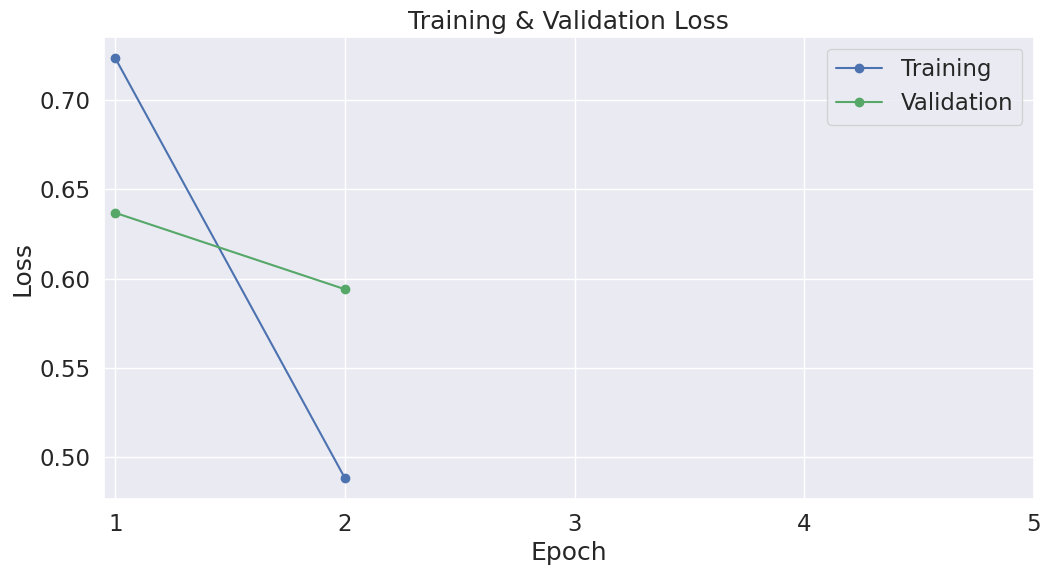

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

13. Load and test the model.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(output_dir)
aira = AutoModelForCausalLM.from_pretrained(output_dir)

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    temperature=0.7,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    # print only the response and remove the question
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')


Enter your question: What is the capital of France?
Question: 👤 What is the capital of France?

Response 1: 🤖 The capital of France is Paris.
Response 2: 🤖 The capital of France is Paris.


Done! 🤗